# Tutorial - Water Temperature

## Content
* [Setup](#Setup)
* [1. Data](#Data)
    * [1.1. Load Data](#LoadData)
    * [1.2. Filter Shapefiles](#FilterShapefiles)
    * [1.3. Filter Landsat Images](#FilterLandsatImages)
    * [1.4. Prepare Landsat Images](#PrepareLandsatImages)
* [2. Normalized Difference Water Index](#NDWI)
* [3. Temperature Band](#TemperatureBand)
* [4. Extraction of Water Temperature](#ExtractionOfWaterTemperature)
    * [4.1. Mosaic Landsat Images](#MosaicLandsatImages)
    * [4.2. Mask Out Water Pixels](#MaskOutWaterPixels)
    * [4.3. Generate Temperature Time Series](#GenerateTimeSeries)
    * [4.4. Plot Temperature Time Series](#PlotTimeSeries)

## Setup <a class="anchor" id="Setup"></a>

In [1]:
# # Install the Earth Engine Python API (https:#developers.google.com/earth-engine)
# ! conda install -c conda-forge earthengine-api -y 
# ! conda install -c conda-forge geemap -y # Install Geemap package (https:#geemap.org/)
# ! conda install numpy -y # Install NumPy (https:#numpy.org/)
# ! conda install -c conda-forge pandas -y # Install Pandas (https:#pandas.pydata.org/)
# ! conda install -c conda-forge matplotlib -y # Install Matplotlib (https:#matplotlib.org/)
# ! conda install -c conda-forge geopandas -y # Install GeoPandas (https:#geopandas.org/)
# ! pip install ipython==8.15.0 # Install IPython (https:#ipython.org/)

In [2]:
import ee # Import Earth Engine API
import geemap # Import Geemap package
import pandas as pd # Import Pandas as pd
import geopandas as gpd # Import GeoPandas as gpd
import numpy as np # Import NumPy as np
import matplotlib.pyplot as plt # Import Matplotlib as plt

In [3]:
# ee.Authenticate()
# ee.Initialize()

In [13]:
# Create a map centered at (lat, lon) 40, -100
Map = geemap.Map(center=[40, -100], zoom=4)
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

## 1. Data <a class="anchor" id="Data"></a>

### 1.1. Load Data  <a class="anchor" id="LoadData"></a>

In [14]:
landsat8 = ee.ImageCollection() #** enter the path to the Landsat 8 image collection
downstream = ee.FeatureCollection() #** enter the path to the downstream reach shapefile
reservoir = ee.FeatureCollection() #** enter the path to the reservoir shapefile

### 1.2. Filter Shapefiles <a class="anchor" id="FilterShapefiles"></a>

In [15]:
downstream = downstream.filter(ee.Filter.eq()) #** enter the condition for filtering out the shapefile
reservoir = reservoir.filter(ee.Filter.eq()) #** enter the condition for filtering out the shapefile

### 1.3. Filter Landsat Images <a class="anchor" id="FilterLandsatImages"></a>

In [16]:
startDate = ee.Date() #** specify the start date for the landsat images
endDate = ee.Date() #** specify the end date for the landsat images

In [17]:
# use the shapefiles and dates to filter out the landsat images
landsat8Filtered = landsat8.filterBounds(reservoir.merge(downstream)).filterDate(
    startDate, endDate
)

In [18]:
# Inspect the first image in the collection
Map.addLayer(
    landsat8Filtered.first(),
    {"bands": []}, #** enter the red, green and blue bandnames
    "Landsat 8 - Raw"
)

### 1.4. Prepare Landsat Images <a class="anchor" id="PrepareLandsatImages"></a>

In [9]:
# function to prepare Landsat 8 images
def prepareLandsat8(image):
    # mask for unwanted pixels (fill, dilated cloud, cirrus, cloud, cloud shadow, snow)
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qa_mask = image.select("QA_PIXEL").bitwiseAnd(int("111111", 2)).eq(0)
    # mask for saturated pixels
    saturation_mask = image.select("QA_RADSAT").eq(0)

    # Apply scaling factors to the surface reflectance and thermal bands
    opticalBands = image.select("SR_B.").multiply().add(); #** enter scaling factors
    thermalBands = image.select("ST_B.*").multiply().add(); #** enter scaling factors

    # Add bands to the image and mask unwanted pixels
    return (
        image.addBands(opticalBands, overwrite=True)
        .addBands(thermalBands, overwrite=True)
        .updateMask(qa_mask)
        .updateMask(saturation_mask)
    )


# map the prepareLandsat8 function over the ImageCollection
landsat8Prep = landsat8.map(prepareLandsat8)

## 2. Normalized Difference Water Index (NDWI) <a class="anchor" id="NDWI"></a>

In [10]:
# function to calculate and add NDWI band
def addNDWI(image):

    # greenBand = "SR_B3"
    # nirBand = "SR_B5"
    # ndvi = image.normalizedDifference(
    #     [nirBand, greenBand]
    # ).rename("NDVI")

    ndwi = image.expression(
        "NDWI = (green - NIR)/(green + NIR)",
        {"green": image.select(), #** enter band name for green
        "NIR": image.select(), #** enter band name for NIR
    }).rename("NDWI")

    return image.addBands(ndwi)

# map the addNDWI function over the ImageCollection
landsat8Ndwi = landsat8.map(addNDWI)

## 3. Temperature Band <a class="anchor" id="TemperatureBand"></a>

In [11]:
# function to calculate and add Celcius band
def addCelsius(image):
    celcius = image.select("ST_B10").subtract(273.15).rename("Celsius")

    return image.addBands(celcius)

# map the addCelcius function over the ImageCollection
landsat8Celsius = landsat8.map(addCelsius)

In [12]:
# Map.addLayer(
#     landsat8Celsius.first(),
#     {"bands": []}, #** enter the red, green and blue bandnames
#     "Landsat 8 - Prepared"
# )

In [ ]:
#?? Can you modify the code to generate images over land instead of water?

## 4. Extraction of Water Temperature <a class="anchor" id="ExtractionOfWaterTemperature"></a>

### 4.1. Mosaic Landsat Images <a class="anchor" id="MosaicLandsatImages"></a>

In [13]:
# sequence mosaic dates monthly
n_monthly = endDate.difference(startDate, "month")
monthlyDates = ee.List.sequence(0, n_monthly.ceil()).map(
    lambda n: ee.DateRange(
        startDate.advance(ee.Number(n), "month"),
        startDate.advance(ee.Number(n).add(1), "month"),
    )
)

# sequence mosaic dates bi-weekly
n_biWeekly = ee.Number(endDate.difference(startDate, "week")).divide(2)
biWeeklyDates = ee.List.sequence(0, n_biWeekly.ceil()).map(
    lambda n: ee.DateRange(
        startDate.advance(ee.Number(n).multiply(2), "week"),
        startDate.advance(ee.Number(n).multiply(2).add(2), "week"),
    )
)

In [14]:
# Specify mosaic date range
# mosaicStartDate = ee.DateRange(dateRange).start()
# mosaicEndDate = ee.DateRange(dateRange).end()
mosaicStartDate = ee.Date("2022-05-01")
mosaicEndDate = ee.Date("2022-05-30")

# Create a mosaic of the Landsat 8 images
mosaic = (
    landsat8.filterBounds(reservoir.merge(downstream))
    .filterDate(mosaicStartDate, mosaicEndDate)
    .map(prepareLandsat8)
    .map(addNDWI)
    .map(addCelsius)
    .mosaic()
)

### 4.2. Mask Out Water Pixels <a class="anchor" id="MaskOutWaterPixels"></a>

In [15]:
# Create a mask for the water pixels using the NDWI band
waterMaskNdwi = mosaic.select("NDWI").gt() #** enter treshold for water pixels

# Create a mask for the water pixels using the QA_PIXEL band
waterMask = (
    mosaic
    .select("QA_PIXEL")
    .bitwiseAnd() #** enter bit value for water
    .neq(0)
)  # bit value for water
mosaic = mosaic.updateMask(waterMask)

In [16]:
# Add the mosaicked and masked image to the map
Map.addLayer(
    mosaic,
    {"bands": ["Celsius"], "min": 5, "max": 35, "palette": ["blue", "green", "red"]},
    "Temperature (C)",
)

In [ ]:
#?? Can you modify the code to generate images over land instead of water?

### 4.3. Generate Temperature Time Series <a class="anchor" id="GenerateTimeSeries"></a>

In [17]:
# Extract water temperature
def extractWaterTemperature(dateRange):
    mosaicStartDate = ee.DateRange(dateRange).start()
    mosaicEndDate = ee.DateRange(dateRange).end()

    mosaic = (
        landsat8
        .filterBounds(reservoir.merge(downstream))
        .filterDate(mosaicStartDate, mosaicEndDate)
        .map(prepareLandsat8)
        .map(addNDWI)
        .map(addCelsius)
        .mosaic()
    )

    # Create a mask for the water pixels using the NDWI band
    waterMaskNdwi = mosaic.select("NDWI").gt() #** enter treshold for water pixels

    # Create a mask for the water pixels using the QA_PIXEL band
    waterMask = (
        mosaic
        .select("QA_PIXEL")
        .bitwiseAnd() #** enter bit value for water
        .neq(0)
    )  # bit value for water
    mosaic = mosaic.updateMask(waterMask)

    # Find the mean values of the Celsius over the reservoir
    meanReservoirTemperature = mosaic.select("Celsius").reduceRegion(
        ee.Reducer.mean(), reservoir.geometry(), 30
    )
    # # Find the mean values of the Celsius downstream
    meanDownstreamTemperature = mosaic.select("Celsius").reduceRegion(
        ee.Reducer.mean(), downstream.geometry(), 30
    )

    return ee.Feature(
        None,
        {
            "date": mosaicStartDate.format("YYYY-MM-dd"),
            "reservoirTemp": ee.Number(meanReservoirTemperature.get('Celsius')),
            "downstreamTemp": ee.Number(meanDownstreamTemperature.get('Celsius')),
        },
    )

In [18]:
# Map the extractWaterTemperature function over date sequence
temperatureSeries = ee.FeatureCollection(
    monthlyDates.map(extractWaterTemperature)
)

### 4.4. Plot Time Series <a class="anchor" id="PlotTimeSeries"></a>

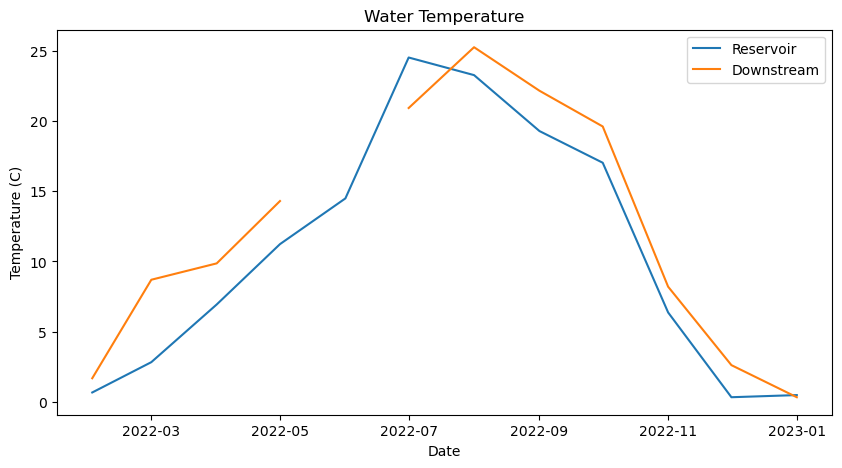

In [19]:
# convert temperature series to pandas dataframe
temperatureSeriesDf = geemap.ee_to_pandas(temperatureSeries)
temperatureSeriesDf["date"] = pd.to_datetime(temperatureSeriesDf["date"])

# plot temperature series
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    temperatureSeriesDf["date"], temperatureSeriesDf["reservoirTemp"], label="Reservoir"
)
ax.plot(
    temperatureSeriesDf["date"],
    temperatureSeriesDf["downstreamTemp"],
    label="Downstream",
)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (C)")
ax.set_title("Water Temperature")
ax.legend()
plt.show()